In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import editdistance
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
sys.path.append('/usr/local/ViennaRNA/lib/python3.7/site-packages/')
%reload_ext autoreload
%autoreload 2
from utils.sequence_utils import *
from models.Theoretical_models import *
from models.Noise_wrapper import *
from exploration_strategies.CE import *
from exploration_strategies.RL_explorers_modify import *
from utils.landscape_utils import *
from models.RNA_landscapes import *
from models.Multi_dimensional_model import *
import RNA

In [14]:
import torch
from torch import nn
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F
import numpy as np

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
RAA="UGCA" #alphabet
length=40

In [17]:
wt=generate_random_sequences(length,1,alphabet=RAA)[0]
wt

'CGUAAACUAAGGUGCUAGGCUCACUAGGUCCUUGGUUUAC'

In [18]:
#make a simple folding landscape starting at wt
landscape1=RNA_landscape(wt)

In [19]:
noise_alpha=1
batch_size=100
virtual_per_measure_ratio=15
temperature=0.1
generations=20

In [20]:
# there are multiple abstract "noise models" you can use, or you can try to train your own model, using skM
noisy_landscape_CE=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
noisy_landscape_RL=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
noisy_landscape_RL_multiple=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
#noisy_landscape=Gaussian_noise_landscape(base_landscape,noise_alpha=0.15)
#noisy_landscape=DF_noise_landscape(base_landscape,noise_alpha=0.5)

In [21]:
batch_size = 10
initial_genotypes=list(set([wt]+[generate_random_mutant(wt,0.05,RAA) for i in range(batch_size*10)]))[:batch_size]
len(initial_genotypes)

10

# Cross Entropy

In [22]:
# batch_size=10
# generations=10

# noisy_landscape_CE.reset()
# noisy_landscape_CE.measure_true_landscape(initial_genotypes)
# noisy_landscape_CE.natural_mode=False
# noisy_landscape_CE.local_mode=False
# noisy_landscape_CE.cost

# eCE=CE(noisy_landscape_CE,initial_genotypes,wt,\
#        alphabet=RAA,batch_size=batch_size,recomb_rate=0.0, \
#        temperature=temperature,virtual_screen=virtual_per_measure_ratio)

# news=[]
# CE_top_seqs = []
# while noisy_landscape_CE.cost<generations*batch_size:
#     news.append(eCE.pick_action())

#     print(noisy_landscape_CE.cost,eCE.top_sequence[-1][0])
#     CE_top_seqs += [(noisy_landscape_CE.cost, eCE.top_sequence[-1][0])]
#     news=[]

# One RL agent, epsilon greedy

In [23]:
# batch_size=10
# generations=10

# noisy_landscape_RL.reset()
# noisy_landscape_RL.measure_true_landscape(initial_genotypes)
# noisy_landscape_RL.natural_mode=False
# noisy_landscape_RL.local_mode=False
# noisy_landscape_RL.cost

# agent = RL_agent_QN(wt,alphabet=RAA,memory_size=10000)
# observations=[x for x in initial_genotypes]#agent.observe(noisy_landscape_RL,initial_genotypes,costly=True,num_observations=100,depth=5)
# # agent.train_actor(noisy_landscape_RL,observations, train_epochs=10)
# new_sequences = sorted([(noisy_landscape_RL.get_fitness(observations[i]),[observations[i]])
#                         for i in range(len(observations))])

# RL_top_seqs = []
# while noisy_landscape_RL.cost<batch_size*generations:
#     eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
#     method = ('e', eps)
#     b = 0
#     new = []
#     while(b < batch_size):
#         s = agent.pick_action(method)
#         if not s in noisy_landscape_RL.measured_sequences.keys():
#             new += [s]
#             b += 1
# #     new=[agent.pick_action_epsilon_greedy(epsilon=eps) for _ in range(batch_size)]
#     noisy_landscape_RL.measure_true_landscape(new)
#     observations += new
#     avg_loss = agent.train_actor(noisy_landscape_RL,observations, train_epochs=20)
#     print (noisy_landscape_RL.cost, noisy_landscape_RL.get_fitness(new_sequences[-1][1][0]), avg_loss)
#     new_sequences += [(noisy_landscape_RL.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
#     new_sequences = sorted(new_sequences)
    
#     RL_top_seqs += [(noisy_landscape_RL.cost, new_sequences[-1][0])]


# Comparison plotting

In [37]:
def run_CE(initial_genotypes, batch_size, generations):
    noisy_landscape_CE.reset()
    noisy_landscape_CE.measure_true_landscape(initial_genotypes)
    noisy_landscape_CE.natural_mode=False
    noisy_landscape_CE.local_mode=False
    noisy_landscape_CE.cost

    eCE=CE(noisy_landscape_CE,initial_genotypes,wt,\
           alphabet=RAA,batch_size=batch_size,recomb_rate=0.0, \
           temperature=temperature,virtual_screen=virtual_per_measure_ratio)

    news=[]
    CE_top_seqs = []
    while noisy_landscape_CE.cost<generations*batch_size:
        news.append(eCE.pick_action())

        print(noisy_landscape_CE.cost,eCE.top_sequence[-1][0])
        CE_top_seqs += [(noisy_landscape_CE.cost, eCE.top_sequence[-1][0])]
        news=[]
        
    return CE_top_seqs

def run_RL(initial_genotypes, batch_size, generations, sampling_method):
    noisy_landscape_RL.reset()
    noisy_landscape_RL.measure_true_landscape(initial_genotypes)
    noisy_landscape_RL.natural_mode=False
    noisy_landscape_RL.local_mode=False
    noisy_landscape_RL.cost

    agent = RL_agent_QN(wt,alphabet=RAA,memory_size=10000, device=device)
    observations=[x for x in initial_genotypes]#agent.observe(noisy_landscape_RL,initial_genotypes,costly=True,num_observations=100,depth=5)
    agent.train_actor(noisy_landscape_RL,observations, train_epochs=10)
    new_sequences = sorted([(noisy_landscape_RL.get_fitness(observations[i]),[observations[i]])
                            for i in range(len(observations))])

    RL_top_seqs = []
    while noisy_landscape_RL.cost<batch_size*generations:
        if(sampling_method=='eps' or sampling_method=='neps'):
            eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
            method = (sampling_method, eps)
        if(sampling_method=='greedy_future'):
            eps = 0.05
            method = (sampling_method, eps)
        else:
            method = (sampling_method,)
        
        b = 0
        new = []
        while(b < batch_size):
            s = agent.pick_action(method)
            if not s in noisy_landscape_RL.measured_sequences.keys():
                new += [s]
                b += 1
    #     new=[agent.pick_action_epsilon_greedy(epsilon=eps) for _ in range(batch_size)]
        noisy_landscape_RL.measure_true_landscape(new)
        observations += new
        avg_loss = agent.train_actor(noisy_landscape_RL,observations, train_epochs=20)
        print (noisy_landscape_RL.cost, noisy_landscape_RL.get_fitness(new_sequences[-1][1][0]), avg_loss)
        new_sequences += [(noisy_landscape_RL.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
        new_sequences = sorted(new_sequences)

        RL_top_seqs += [(noisy_landscape_RL.cost, new_sequences[-1][0])]
    return RL_top_seqs

def get_CE_data(trials=10, batch_size=10, generations=10, verbose=False):
    '''
    runs n trials of CE; returns lists of (lists of top seqs)
    '''
    
    trial_data = []
    
    for _ in range(trials):
        noisy_landscape_CE.reset()
        noisy_landscape_CE.measure_true_landscape(initial_genotypes)
        noisy_landscape_CE.natural_mode=False
        noisy_landscape_CE.local_mode=False
        noisy_landscape_CE.cost

        eCE=CE(noisy_landscape_CE,initial_genotypes,wt,\
               alphabet=RAA,batch_size=batch_size,recomb_rate=0.0, \
               temperature=temperature,virtual_screen=virtual_per_measure_ratio)

        news=[]
        CE_top_seqs = []
        while noisy_landscape_CE.cost<generations*batch_size:
            news.append(eCE.pick_action())
            if verbose:
                print(noisy_landscape_CE.cost,eCE.top_sequence[-1][0])
            CE_top_seqs += [(noisy_landscape_CE.cost, eCE.top_sequence[-1][0])]
            news=[]
        trial_data.append(CE_top_seqs)
        
    return trial_data

def get_RL_data(trials=10, batch_size=10, generations=10, verbose=False):
    '''
    runs n trials of RL with eps greedy; returns lists of (lists of top seqs)
    '''
    
    trial_data = []
    
    for _ in range(trials):
        noisy_landscape_RL.reset()
        noisy_landscape_RL.measure_true_landscape(initial_genotypes)
        noisy_landscape_RL.natural_mode=False
        noisy_landscape_RL.local_mode=False
        noisy_landscape_RL.cost

        agent = RL_agent_QN(wt,alphabet=RAA,memory_size=10000)
        observations=[x for x in initial_genotypes]#agent.observe(noisy_landscape_RL,initial_genotypes,costly=True,num_observations=100,depth=5)
        # agent.train_actor(noisy_landscape_RL,observations, train_epochs=10)
        new_sequences = sorted([(noisy_landscape_RL.get_fitness(observations[i]),[observations[i]])
                                for i in range(len(observations))])

        RL_top_seqs = []
        while noisy_landscape_RL.cost<batch_size*generations:
            eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
            method = ('eps', eps)
            b = 0
            new = []
            while(b < batch_size):
                s = agent.pick_action(method)
                if not s in noisy_landscape_RL.measured_sequences.keys():
                    new += [s]
                    b += 1
        #     new=[agent.pick_action_epsilon_greedy(epsilon=eps) for _ in range(batch_size)]
            noisy_landscape_RL.measure_true_landscape(new)
            observations += new
            avg_loss = agent.train_actor(noisy_landscape_RL,observations, train_epochs=20)
            if verbose:
                print (noisy_landscape_RL.cost, noisy_landscape_RL.get_fitness(new_sequences[-1][1][0]), avg_loss)
            new_sequences += [(noisy_landscape_RL.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
            new_sequences = sorted(new_sequences)

            RL_top_seqs += [(noisy_landscape_RL.cost, new_sequences[-1][0])]
        trial_data.append(RL_top_seqs)
        
    return trial_data

def plot_max_min_data(CE_data, RL_data, batch_size, generations, labels):
    CE_data = np.array(CE_data)
    RL_data = np.array(RL_data)
    _, ax = plt.subplots()
    
    tmp = np.concatenate(CE_data)
    costs = np.unique(tmp[:,0])
    max_fitnesses = []
    min_fitnesses = []
    mean_fitnesses = []
    for i in costs:
        fitnesses = tmp[np.where(tmp[:,0] == i)][:,1]
        max_fitnesses.append(np.max(fitnesses))
        min_fitnesses.append(np.min(fitnesses))
        mean_fitnesses.append(np.mean(fitnesses))

    ax.plot(costs, mean_fitnesses, lw=1, color='blue', alpha=1, label=labels[0])
    ax.fill_between(costs, min_fitnesses, max_fitnesses, color='blue', alpha=0.4)
    
    tmp = np.concatenate(RL_data)
    costs = np.unique(tmp[:,0])
    max_fitnesses = []
    min_fitnesses = []
    mean_fitnesses = []
    cost_intervals = []
    # need to merge interval data since the intervals in RL are not as regular as CE
    for i in np.linspace(0, batch_size*generations, 11):
        indices = np.intersect1d(np.where(i <= tmp[:,0]), np.where(tmp[:,0] < i+10))
        if len(indices) == 0:
            continue
        cost_intervals.append(i)
        fitnesses = tmp[indices][:,1]
        max_fitnesses.append(np.max(fitnesses))
        min_fitnesses.append(np.min(fitnesses))
        mean_fitnesses.append(np.mean(fitnesses))

    ax.plot(cost_intervals, mean_fitnesses, lw=1, color='orange', alpha=1, label=labels[1])
    ax.fill_between(cost_intervals, min_fitnesses, max_fitnesses, color='orange', alpha=0.4)

    ax.set_xlabel("Costs")
    ax.set_ylabel("Fitnesses")
    ax.set_ylim(0, 1)
    plt.title("Batch Size={}, Generations={}".format(batch_size, generations))
    plt.legend()
    plt.show()
    
def plot_data(CE_data, RL_data, batch_size, generations, labels):
    CE_data = np.array(CE_data)
    RL_data = np.array(RL_data)
    _, ax = plt.subplots()
    
    tmp = np.concatenate(CE_data)
    costs = np.unique(tmp[:,0])
    stdev_fitnesses = []
    mean_fitnesses = []
    for i in costs:
        fitnesses = tmp[np.where(tmp[:,0] == i)][:,1]
        stdev_fitnesses.append(np.std(fitnesses))
        mean_fitnesses.append(np.mean(fitnesses))

    ax.plot(costs, mean_fitnesses, lw=1, color='blue', alpha=1, label=labels[0])
    ax.fill_between(costs, np.subtract(mean_fitnesses,stdev_fitnesses), np.add(mean_fitnesses,stdev_fitnesses), color='blue', alpha=0.4)
    
    tmp = np.concatenate(RL_data)
    costs = np.unique(tmp[:,0])
    stdev_fitnesses = []
    mean_fitnesses = []
    cost_intervals = []
    # need to merge interval data since the intervals in RL are not as regular as CE
    for i in np.linspace(0, batch_size*generations, 11):
        indices = np.intersect1d(np.where(i <= tmp[:,0]), np.where(tmp[:,0] < i+10))
        if len(indices) == 0:
            continue
        cost_intervals.append(i)
        fitnesses = tmp[indices][:,1]
        stdev_fitnesses.append(np.std(fitnesses))
        mean_fitnesses.append(np.mean(fitnesses))

    ax.plot(cost_intervals, mean_fitnesses, lw=1, color='orange', alpha=1, label=labels[1])
    ax.fill_between(cost_intervals, np.subtract(mean_fitnesses,stdev_fitnesses), np.add(mean_fitnesses,stdev_fitnesses), color='orange', alpha=0.4)

    ax.set_xlabel("Costs")
    ax.set_ylabel("Fitnesses")
    ax.set_ylim(0, 1)
    plt.title("Batch Size={}, Generations={}".format(batch_size, generations))
    plt.legend()
    plt.show()

# plt.figure(figsize=(10,5))
# plt.xlabel("cost")
# plt.ylabel("maximum fitness observed")
# plt.plot([s[0] for s in CE_top_seqs], [s[1] for s in CE_top_seqs],label="eCE")
# plt.plot([s[0] for s in RL_top_seqs], [s[1] for s in RL_top_seqs],label="RL")

# plt.legend()
# plt.show()

In [25]:
# CE_data = get_CE_data(trials=10,batch_size=10,generations=20)
# RL_data = get_RL_data(trials=10,batch_size=10,generations=20,verbose=True)

In [26]:
# # Note, probably will need to change some of the variables if you change batch/generation

# plot_data(CE_data, RL_data)

# One RL agent, Boltzmann sampling (?)

In [27]:
# class Model(nn.Module):
#     def __init__(self, sequence_len, alphabet_len):
#         super(Model,self).__init__()
#         self.sequence_len = sequence_len
#         self.alphabet_len = alphabet_len
#         self.linear1 = nn.Linear(alphabet_len * sequence_len, alphabet_len * sequence_len)
#         self.linear2 = nn.Linear(alphabet_len * sequence_len, sequence_len)
#         self.linear3 = nn.Linear(sequence_len, sequence_len)
#         self.linear4 = nn.Linear(sequence_len, 18)
#         self.linear5 = nn.Linear(18, alphabet_len * sequence_len)
#         self.linear6 = nn.Linear(alphabet_len * sequence_len, alphabet_len * sequence_len)
#         self.linear_final = nn.Linear(sequence_len, sequence_len)
    
#     def forward(self, x):
#         x = x.view(-1, self.alphabet_len*self.sequence_len)
#         x = F.relu(self.linear1(x))
#         x = F.relu(self.linear2(x))
#         x = F.relu(self.linear3(x))
#         x = F.relu(self.linear4(x))
#         x = F.relu(self.linear5(x))
#         x = F.relu(self.linear6(x))
#         x = x.view([-1]+list((self.alphabet_len, self.sequence_len)))
#         x = self.linear_final(x)
#         return x
    
    
# def build_model(sequence_len, alphabet_len):
#     model = Model(sequence_len, alphabet_len)
    
#     return model

# class RL_agent_QN():

#     def __init__(self,start_sequence,alphabet,gamma=0.9,memory_size=1000):
#         self.alphabet=alphabet
#         self.state=translate_string_to_one_hot(start_sequence,self.alphabet)
#         self.seq_size=len(start_sequence)
#         self.actor=build_model(self.seq_size,len(self.alphabet))
#         self.start_sequence=translate_string_to_one_hot(start_sequence,self.alphabet)
#         self.gamma=gamma
#         self.memory=[]
#         self.memory_size=memory_size

#     def reset_position(self,sequence):
#         self.state=translate_string_to_one_hot(sequence,self.alphabet)

#     def get_position(self):
#         return translate_one_hot_to_string(self.state,self.alphabet)

#     def translate_pwm_to_sequence(self,input_seq_one_hot,output_pwm):
#         diff=output_pwm-input_seq_one_hot
#         most_likely=np.argmax(diff,axis=0)
#         out_seq=""
#         for m in most_likely:
#             out_seq+=self.alphabet[m]
#         return out_seq

#     def observe(self,landscape,genotypes,costly=False,num_observations=50,epsilon=0.2,depth=10):
#         if genotypes:
#             new_sequences=make_one_hot_genotypes(genotypes,self.alphabet)
#         elif self.memory:
#             new_sequences=make_one_hot_genotypes(self.memory[-num_observations:],self.alphabet)
#         else:
#             return "Nothing to observe"
#         new_moves=[]
#         all_moves=[]
        
#         #all_fitnesses=[]
#         for i in range(depth):
#             for genotype in new_sequences:
#                 if random.random()<epsilon:
#                     genotype_tensor = torch.from_numpy(np.expand_dims(genotype,axis=0)).float()
#                     prediction = self.actor(genotype_tensor)
#                     prediction = prediction.detach().numpy()[0]
#                     #moves=walk_away_renormalize_moves(genotype,self.start_sequence,prediction)
#                     moves=renormalize_moves(genotype,prediction)

#                     sample=sample_random(moves)
#                     mutant=construct_mutant_from_sample(sample,genotype)
#                     new_moves.append(translate_one_hot_to_string(mutant,self.alphabet))
#                 else:
#                     genotype_tensor = torch.from_numpy(np.expand_dims(genotype,axis=0)).float()
#                     prediction = self.actor(genotype_tensor)
#                     prediction = prediction.detach().numpy()[0]
#                     #moves=walk_away_renormalize_moves(genotype,self.start_sequence,prediction)
#                     moves=renormalize_moves(genotype,prediction)
                    
#                     sample=sample_boltzman(moves)
#                     mutant=construct_mutant_from_sample(sample,genotype)
#                     new_moves.append(translate_one_hot_to_string(mutant,self.alphabet))
#             if costly:
#                 landscape.measure_true_landscape(new_moves)
# #             else:
# #                 landscape.genotype_fitnesses(new_moves)

#             new_sequences=np.stack([translate_string_to_one_hot(move,self.alphabet) for move in new_moves])
#             all_moves.extend(new_moves)
#             #all_fitnesses.append(new_fitnesses)
#             new_moves=[]
#         self.memory=all_moves[-self.memory_size:] #store at most 1000 memories
#         return all_moves

#     def train_actor(self, landscape, observations, train_epochs=10):
#         loss_fxn = nn.MSELoss()
#         optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
#         total_loss = 0.
#         for epoch in range(train_epochs):     
#             moves = observations #random.sample(observations, train_size)
#             genotypes_one_hot, genotype_fitnesses, t_1, t_2 = make_one_hot_train_test(moves, landscape, self.alphabet)
#             optimizer.zero_grad()
#             genotypes_one_hot_tensor = torch.from_numpy(genotypes_one_hot).float()
#             outputs = self.actor(genotypes_one_hot_tensor)
#             genotype_fitnesses = torch.tensor(genotype_fitnesses, requires_grad=True).float()
#             loss = loss_fxn(outputs, genotype_fitnesses)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
# #         print('[%d] Avg loss: %.3f' % (epoch+1, total_loss / (epoch + 1)))
#         return (total_loss / (epoch+1))

#     def xtrain_actor(self,landscape, observations,train_size=1000,train_epochs=1):
#         loss_fxn = nn.MSELoss()
#         optimizer = optim.Adam(net.parameters, lr=0.001)
#         for epoch in range(train_epochs):  # loop over the dataset multiple times
#             running_loss = 0.0
            
#             moves = random.sample(observations,train_size)+random.sample(self.memory,train_size)
#             genotypes_one_hot, genotype_fitnesses, t_1, t_2 = make_one_hot_train_test(moves, landscape, self.alphabet)
            
#             optimizer.zero_grad()
            
#             outputs = self.actor(genotypes_one_hot)
#             loss = loss_fxn(outputs, genotype_fitnesses)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()
#             if i % 2000 == 1999:    # print every 2000 mini-batches
#                     print('[%d, %5d] loss: %.3f' %
#                           (epoch + 1, i + 1, running_loss / 2000))
#                     running_loss = 0.0

#     def pick_action_epsilon_greedy(self,epsilon=0.1):
#         state_tensor = torch.from_numpy(np.expand_dims(self.state,axis=0)).float()
#         prediction=self.actor(state_tensor)
#         prediction = prediction.detach().numpy()[0]
#         #moves=walk_away_renormalize_moves(self.state,self.start_sequence,prediction)
#         moves=renormalize_moves(self.state,prediction)
# #             print(self.state)
# #             print(state_tensor)
# #             print(prediction)
#         if random.random()<epsilon:
#             sample=sample_random(moves)
# #                 print("eps", sample)
#             mutant=construct_mutant_from_sample(sample,self.state)
#             mutant_string=translate_one_hot_to_string(mutant,self.alphabet)
#         else:
#             sample=sample_greedy(moves)
# #                 print("greedy", sample)
#             mutant=construct_mutant_from_sample(sample,self.state)
#             mutant_string=translate_one_hot_to_string(mutant,self.alphabet)

#         self.state=mutant
#         self.memory.append(mutant_string)

#         return mutant_string
        
#     def pick_action_epsilon_greedy_boltzmann(self,epsilon=0.1):
#         state_tensor = torch.from_numpy(np.expand_dims(self.state,axis=0)).float()
#         prediction=self.actor(state_tensor)
#         prediction = prediction.detach().numpy()[0]
#         #moves=walk_away_renormalize_moves(self.state,self.start_sequence,prediction)
#         moves=renormalize_moves(self.state,prediction)
# #             print(self.state)
# #             print(state_tensor)
# #             print(prediction)

#         if random.random()<epsilon:
#             sample=sample_boltzman(moves)
# #                 print("eps", sample)
#             mutant=construct_mutant_from_sample(sample,self.state)
#             mutant_string=translate_one_hot_to_string(mutant,self.alphabet)
#         else:
#             sample=sample_greedy(moves)
# #                 print("greedy", sample)
#             mutant=construct_mutant_from_sample(sample,self.state)
#             mutant_string=translate_one_hot_to_string(mutant,self.alphabet)

#         self.state=mutant
#         self.memory.append(mutant_string)

#         return mutant_string

In [28]:
# batch_size=10
# generations=10

# noisy_landscape_RL.reset()
# noisy_landscape_RL.measure_true_landscape(initial_genotypes)
# noisy_landscape_RL.natural_mode=False
# noisy_landscape_RL.local_mode=False
# noisy_landscape_RL.cost

# agent = RL_agent_QN(wt,alphabet=RAA,memory_size=10000)
# observations=[x for x in initial_genotypes]#agent.observe(noisy_landscape_RL,initial_genotypes,costly=True,num_observations=100,depth=5)
# # agent.train_actor(noisy_landscape_RL,observations, train_epochs=10)
# new_sequences = sorted([(noisy_landscape_RL.get_fitness(observations[i]),[observations[i]])
#                         for i in range(len(observations))])

# RL_top_seqs = []
# while noisy_landscape_RL.cost<batch_size*generations:
#     eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
#     b = 0
#     new = []
#     while(b < batch_size):
#         s = agent.pick_action_epsilon_greedy_boltzmann(eps)
#         if not s in noisy_landscape_RL.measured_sequences.keys():
#             new += [s]
#             b += 1
# #     new=[agent.pick_action_epsilon_greedy(epsilon=eps) for _ in range(batch_size)]
#     noisy_landscape_RL.measure_true_landscape(new)
#     observations += new
#     avg_loss = agent.train_actor(noisy_landscape_RL,observations, train_epochs=20)
#     print (noisy_landscape_RL.cost, noisy_landscape_RL.get_fitness(new_sequences[-1][1][0]), avg_loss)
#     new_sequences += [(noisy_landscape_RL.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
#     new_sequences = sorted(new_sequences)
    
#     RL_top_seqs += [(noisy_landscape_RL.cost, new_sequences[-1][0])]


# Multi-agent RL

In [29]:
from exploration_strategies.RL_explorers_multi_agent import *

In [30]:
noise_alpha=1
batch_size=20
virtual_per_measure_ratio=15
temperature=0.1
generations=20

def run_RL_multi_agent(initial_genotypes, batch_size, generations, sampling_method, num_agents=10):
    noisy_landscape_RL_multiple.reset()
    noisy_landscape_RL_multiple.measure_true_landscape(initial_genotypes)
    noisy_landscape_RL_multiple.natural_mode=False
    noisy_landscape_RL_multiple.local_mode=False
    noisy_landscape_RL_multiple.cost

    multi_agents = RL_multi_agent_QN(RL_agent_QN,
                              noisy_landscape_RL_multiple,
                              wt,
                              RAA,
                              num_agents,
                              memory_size=batch_size)

    # setting different initial positions for each
    for i in range(num_agents):
        multi_agents.agents[i].reset_position(initial_genotypes[i])

    observations = [x for x in initial_genotypes]
    new_sequences = sorted([(noisy_landscape_RL_multiple.get_fitness(observations[i]),[observations[i]])
                            for i in range(len(observations))])

    multi_RL_top_seqs = []
    
    while noisy_landscape_RL_multiple.cost < batch_size * generations:
        if (sampling_method=='eps'):
            eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
            method = (sampling_method, eps)
        elif sampling_method=='greedy_future':
            eps = 0.05
            method = (sampling_method, eps)
        else:
            method = (sampling_method,)
        
        b = 0
        new = []
        while(b < batch_size):
            seqs = multi_agents.pick_action(method)
            for s in seqs:
                if not s in noisy_landscape_RL_multiple.measured_sequences.keys():
                    new += [s]
                    b += 1

        noisy_landscape_RL_multiple.measure_true_landscape(new)
        observations += new
    #     multi_agents.force_observations(observations)
        avg_loss = multi_agents.train_agents(observations)
        print(noisy_landscape_RL_multiple.cost, noisy_landscape_RL_multiple.get_fitness(new_sequences[-1][1][0]), avg_loss)
        new_sequences += [(noisy_landscape_RL_multiple.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
        new_sequences = sorted(new_sequences)
        multi_RL_top_seqs += [(noisy_landscape_RL_multiple.cost, new_sequences[-1][0])]
        
    return multi_RL_top_seqs

In [31]:
# RL_multi_agent_data = run_RL_multi_agent(initial_genotypes, 10, 10, 'eps')

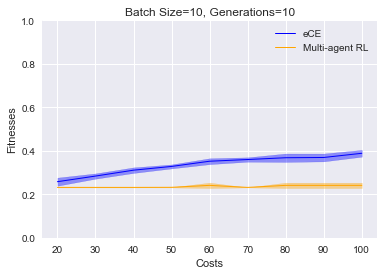

In [38]:
trials = 3
batch_size = 10
generations = 10
num_agents = 10
CE_data = [run_CE(initial_genotypes, batch_size, generations) for _ in range(trials)]
RL_data = [run_RL_multi_agent(initial_genotypes, batch_size, generations, 'eps', num_agents) for _ in range(trials)]
for datum in CE_data:
    np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
                batch_size=batch_size, generations=generations), datum)
for datum in RL_data:
    np.save('./simulations/MARL/batch{batch_size}_generations{generations}'.format(
                batch_size=batch_size, generations=generations), datum)
plot_data(CE_data,
          RL_data,
          batch_size=batch_size,
          generations=generations,
          labels=("eCE", "Multi-agent RL")
         )

20 0.27058823529411763
30 0.31882353389964385
40 0.31882353389964385
50 0.3305882397819968
60 0.34588234845329735
70 0.36352940727682675
80 0.3729411854463465
90 0.3729411854463465
100 0.3729411854463465
110 0.38117648853975183
120 0.4070588055778952
130 0.4070588055778952
140 0.4070588055778952
150 0.40823530309340533
160 0.43294116749482997
170 0.44352942074046414
180 0.46117647956399355
190 0.46117647956399355
200 0.46117647956399355
210 0.46705883250517005
220 0.46705883250517005
230 0.4764705882352941
240 0.48470589132869946
250 0.48470589132869946
260 0.48470589132869946
270 0.5023529501522288
280 0.5023529501522288
290 0.5023529501522288
300 0.5035294027889476
310 0.5047059003044577
320 0.5047059003044577
330 0.5047059003044577
340 0.5047059003044577
350 0.5047059003044577
360 0.5082353030934054
370 0.5117647058823529
380 0.5294117647058824
390 0.5294117647058824
400 0.5294117647058824
410 0.5317647148581112
420 0.5317647148581112
430 0.5317647148581112
440 0.5647058823529412
45

472 0.3870588414809283 0.0006783215572068003
482 0.3870588414809283 0.0006509754396392964
492 0.3870588414809283 0.0006512597203254699
502 0.3870588414809283 0.0006222195136069786


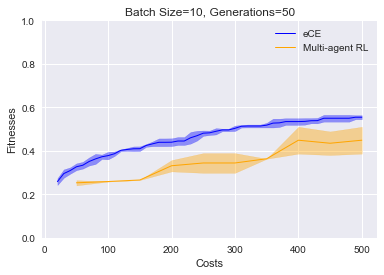

In [39]:
trials = 3
batch_size = 10
generations = 50
num_agents = 10
CE_data = [run_CE(initial_genotypes, batch_size, generations) for _ in range(trials)]
RL_data = [run_RL_multi_agent(initial_genotypes, batch_size, generations, 'eps', num_agents) for _ in range(trials)]
for datum in CE_data:
    np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
                batch_size=batch_size, generations=generations), datum)
for datum in RL_data:
    np.save('./simulations/MARL/batch{batch_size}_generations{generations}'.format(
                batch_size=batch_size, generations=generations), datum)
plot_data(CE_data,
          RL_data,
          batch_size=batch_size,
          generations=generations,
          labels=("eCE", "Multi-agent RL")
         )

20 0.25882352941176473
30 0.2623529322007123
40 0.2964705972110524
50 0.32235293668859144
60 0.32235293668859144
70 0.33647059272317326
80 0.34352942074046416
90 0.3682352851418888
100 0.38117648853975183
110 0.39176469690659466
120 0.4023529501522289
130 0.4023529501522289
140 0.4105882532456342
150 0.4105882532456342
160 0.4105882532456342
170 0.41882351146024815
180 0.41882351146024815
190 0.4305882173426011
200 0.4305882173426011
210 0.4317647148581112
220 0.4317647148581112
230 0.4376470677992877
240 0.4376470677992877
250 0.46235293220071233
260 0.46235293220071233
270 0.46235293220071233
280 0.4858823439654182
290 0.4858823439654182
300 0.4858823439654182
310 0.4858823439654182
320 0.4858823439654182
330 0.4858823439654182
340 0.4858823439654182
350 0.4858823439654182
360 0.4858823439654182
370 0.4952940996955423
380 0.4952940996955423
390 0.4952940996955423
400 0.4952940996955423
410 0.4952940996955423
420 0.4952940996955423
430 0.4952940996955423
440 0.4952940996955423
450 0.5

58 0.2317647148581112 0.0006422859369195066
69 0.2317647148581112 0.0007298198353964836
79 0.2317647148581112 0.0005608982290141284
88 0.2317647148581112 0.0004840095731196925
98 0.2317647148581112 0.0005215315461100545
108 0.2317647148581112 0.0005823259896715171
119 0.2317647148581112 0.0005481789128680247
127 0.2317647148581112 0.000535096423845971
137 0.2317647148581112 0.0005875153285160196
147 0.2317647148581112 0.0005359024391509593
157 0.2317647148581112 0.0005578132528171409
167 0.2317647148581112 0.0005856562092958484
176 0.2317647148581112 0.0005724754460970871
186 0.2317647148581112 0.0005847134925716091
196 0.2317647148581112 0.0005775276025815402
206 0.2317647148581112 0.0005628172169963363
215 0.2317647148581112 0.0005609813189948909
225 0.2317647148581112 0.0005545335523493122
235 0.2317647148581112 0.0005278875418298413
245 0.2317647148581112 0.0005250228510703892
255 0.2317647148581112 0.0005475129823025781
265 0.2529411764705882 0.0005725052396883257
274 0.2564705792

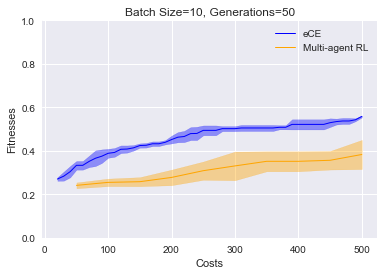

In [40]:
trials = 3
batch_size = 10
generations = 50
num_agents = 2
CE_data = [run_CE(initial_genotypes, batch_size, generations) for _ in range(trials)]
RL_data = [run_RL_multi_agent(initial_genotypes, batch_size, generations, 'eps', num_agents) for _ in range(trials)]
np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
            batch_size=batch_size, generations=generations), CE_data)
np.save('./simulations/MARL/batch{batch_size}_generations{generations}'.format(
            batch_size=batch_size, generations=generations), RL_data)
plot_data(CE_data,
          RL_data,
          batch_size=batch_size,
          generations=generations,
          labels=("eCE", "Multi-agent RL")
         )

In [30]:
# noise_alpha=1
# batch_size=20
# virtual_per_measure_ratio=15
# temperature=0.1
# generations=20

# def run_RL_multi_agent_xtrain(initial_genotypes, batch_size, generations, sampling_method, num_agents=10):
#     noisy_landscape_RL_multiple.reset()
#     noisy_landscape_RL_multiple.measure_true_landscape(initial_genotypes)
#     noisy_landscape_RL_multiple.natural_mode=False
#     noisy_landscape_RL_multiple.local_mode=False
#     noisy_landscape_RL_multiple.cost

#     multi_agents = RL_multi_agent_QN(RL_agent_QN,
#                               noisy_landscape_RL_multiple,
#                               wt,
#                               RAA,
#                               num_agents,
#                               memory_size=batch_size)

#     # setting different initial positions for each
#     for i in range(num_agents):
#         multi_agents.agents[i].reset_position(initial_genotypes[i])

#     observations = [x for x in initial_genotypes]
#     new_sequences = sorted([(noisy_landscape_RL_multiple.get_fitness(observations[i]),[observations[i]])
#                             for i in range(len(observations))])

#     multi_RL_top_seqs = []
    
#     while noisy_landscape_RL_multiple.cost < batch_size * generations:
#         if (sampling_method=='eps'):
#             eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
#             method = (sampling_method, eps)
#         elif sampling_method=='greedy_future':
#             eps = 0.05
#             method = (sampling_method, eps)
#         else:
#             method = (sampling_method,)
        
#         b = 0
#         new = []
#         while(b < batch_size):
#             seqs = multi_agents.pick_action(method)
#             for s in seqs:
#                 if not s in noisy_landscape_RL_multiple.measured_sequences.keys():
#                     new += [s]
#                     b += 1

#         noisy_landscape_RL_multiple.measure_true_landscape(new)
#         observations += new
#     #     multi_agents.force_observations(observations)
#         avg_loss = multi_agents.cross_train_agents(observations)
#         print(noisy_landscape_RL_multiple.cost, noisy_landscape_RL_multiple.get_fitness(new_sequences[-1][1][0]), avg_loss)
#         new_sequences += [(noisy_landscape_RL_multiple.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
#         new_sequences = sorted(new_sequences)
#         multi_RL_top_seqs += [(noisy_landscape_RL_multiple.cost, new_sequences[-1][0])]
        
#     return multi_RL_top_seqs

20 0.22941176470588234
30 0.25647057925953587
40 0.27764706331140854
50 0.30117647507611445
60 0.3423529456643497
70 0.3600000044878791
80 0.3894117467543658
90 0.40941175573012406
100 0.4447058733771829
20 0.17176471037023208
30 0.23058823978199677
40 0.26705883250517004
50 0.28705881904153263
60 0.32588236191693476
70 0.33647059272317326
80 0.38235294117647056
90 0.4176470588235294
100 0.43294116749482997
18 0.09058823305017807 0.008778220508247614
27 0.10470587786506204 0.002124357794673415
35 0.10470587786506204 0.0005948489604634232
43 0.10470587786506204 0.0003056933303014375
48 0.10470587786506204 0.0002801738173729973
56 0.10470587786506204 0.00028031918373017106
65 0.11058823080623852 0.0003045688572456129
73 0.1305882397819968 0.0002866374776203884
81 0.1305882397819968 0.00033111615048255774
92 0.1305882397819968 0.0003459287538134959
101 0.13647059272317325 0.0003428556490689516
19 0.09058823305017807 0.008751293539535254
29 0.09058823305017807 0.002038648462621495
35 0.109

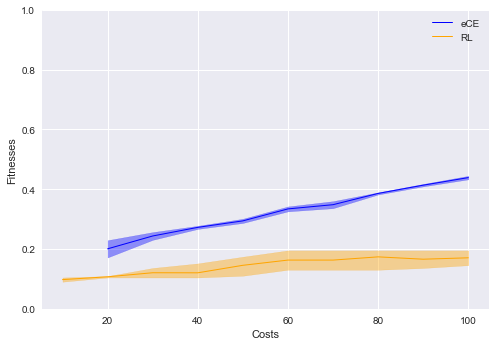

In [41]:
# # eps, boltzmann, thompson, UCB
# plot_data([run_CE(initial_genotypes, 10, 10) for _ in range(2)], [run_RL_multi_agent(initial_genotypes, 10, 10, 'boltzmann', 2) for _ in range(2)])

20 0.23999999551212087
30 0.27647058823529413
40 0.316470583747415
50 0.3176470588235294
60 0.3447058733771829
70 0.3447058733771829
80 0.37176471037023207
90 0.39176469690659466
100 0.40588235294117647
20 0.2317647148581112
30 0.2964705972110524
40 0.29764704984777113
50 0.29764704984777113
60 0.34352942074046416
70 0.34352942074046416
80 0.34588234845329735
90 0.3588235294117647
100 0.3588235294117647
20 0.2517647013944738
30 0.26823528514188877
40 0.3070588280172909
50 0.3552941266228171
60 0.3552941266228171
70 0.38117648853975183
80 0.38235294117647056
90 0.38235294117647056
100 0.38235294117647056
18 0.2317647148581112 0.01335138112772256
26 0.2317647148581112 0.0035284453770145774
35 0.2317647148581112 0.0011425678269006312
42 0.2317647148581112 0.0005738545907661319
50 0.2317647148581112 0.0004361247571068816
59 0.2317647148581112 0.0004375277683720924
66 0.2317647148581112 0.00044677914411295205
74 0.2317647148581112 0.0004199736562441103
81 0.2317647148581112 0.00042988058266

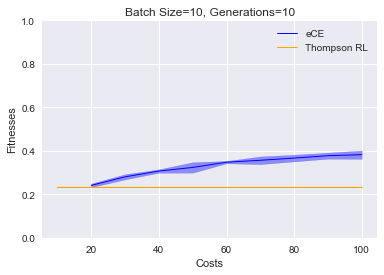

In [47]:
trials = 3
batch_size = 10
generations = 10
CE_data = [run_CE(initial_genotypes, batch_size, generations) for _ in range(trials)]
RL_data = [run_RL(initial_genotypes, batch_size, generations, 'thompson') for _ in range(trials)]
for datum in CE_data:
    np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
                batch_size=batch_size, generations=generations), datum)
for datum in RL_data:
    np.save('./simulations/RL/batch{batch_size}_generations{generations}_thompson'.format(
                batch_size=batch_size, generations=generations), datum)
plot_data(CE_data,
          RL_data,
          batch_size=batch_size,
          generations=generations,
          labels=("eCE", "Thompson RL")
         )

20 0.27058823529411763
30 0.30235295015222885
40 0.31529410867130053
50 0.3658823574290556
60 0.3658823574290556
70 0.3729411854463465
80 0.3799999910242417
90 0.38352939381318935
100 0.38352939381318935
20 0.25882352941176473
30 0.2811764661003562
40 0.30352940278894763
50 0.34588234845329735
60 0.37058823529411766
70 0.37058823529411766
80 0.37058823529411766
90 0.3941176470588235
100 0.4035294027889476
20 0.2517647013944738
30 0.2717647103702321
40 0.28705881904153263
50 0.3235294117647059
60 0.3305882397819968
70 0.33882352043600644
80 0.35764705433565025
90 0.37764704087201284
100 0.37764704087201284
15 0.2317647148581112 0.010008712275885045
22 0.2317647148581112 0.0020963552757166325
30 0.2317647148581112 0.000843753878143616
35 0.2317647148581112 0.0006193050910951569
39 0.2317647148581112 0.0005832209149957635
48 0.2317647148581112 0.000769780931295827
51 0.2317647148581112 0.0012374527228530495
55 0.30117647507611445 0.0012183805811218917
56 0.3941176470588235 0.0010349784715

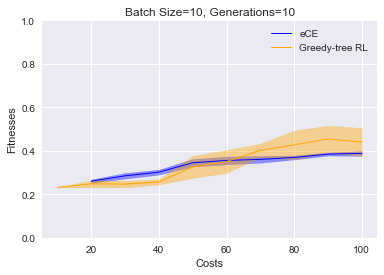

In [44]:
trials = 3
batch_size = 10
generations = 10
CE_data = [run_CE(initial_genotypes, batch_size, generations) for _ in range(trials)]
RL_data = [run_RL(initial_genotypes, batch_size, generations, 'greedy_future') for _ in range(trials)]
np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
            batch_size=batch_size, generations=generations), CE_data)
np.save('./simulations/RL/batch{batch_size}_generations{generations}_greedy-tree'.format(
            batch_size=batch_size, generations=generations), RL_data)
plot_data(CE_data,
          RL_data,
          batch_size=batch_size,
          generations=generations,
          labels=("eCE", "Greedy-tree RL")
         )

20 0.24352942074046416
30 0.2611764795639936
40 0.29529412213493794
50 0.31529410867130053
60 0.3482352986055262
70 0.3658823574290556
80 0.37176471037023207
90 0.37176471037023207
100 0.3952940996955423
20 0.27058823529411763
30 0.29529412213493794
40 0.34588234845329735
50 0.34588234845329735
60 0.34705882352941175
70 0.3682352851418888
80 0.3682352851418888
90 0.37411763808306525
100 0.40588235294117647
20 0.2717647103702321
30 0.32235293668859144
40 0.3494117736816406
50 0.3494117736816406
60 0.3494117736816406
70 0.3494117736816406
80 0.36705883250517
90 0.36705883250517
100 0.3694117602180032
17 0.2317647148581112 0.021571657923050224
27 0.2317647148581112 0.005198905622819439
37 0.2317647148581112 0.0014769694826100022
47 0.2317647148581112 0.00079082823212957
55 0.2317647148581112 0.0008217090959078631
63 0.2317647148581112 0.0007211893069325015
70 0.24588234845329734 0.0007169320058892481
77 0.27647058823529413 0.0008209443942178041
83 0.43529411764705883 0.0011071922446717509

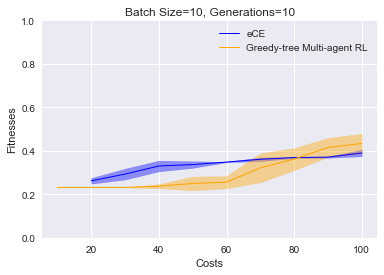

In [45]:
trials = 3
batch_size = 10
generations = 10
num_agents = 2
CE_data = [run_CE(initial_genotypes, batch_size, generations) for _ in range(trials)]
RL_data = [run_RL_multi_agent(initial_genotypes, batch_size, generations, 'greedy_future', num_agents) for _ in range(trials)]
np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
            batch_size=batch_size, generations=generations), CE_data)
np.save('./simulations/MARL/batch{batch_size}_generations{generations}_greedy-tree_2agents'.format(
            batch_size=batch_size, generations=generations), RL_data)
plot_data(CE_data,
          RL_data,
          batch_size=batch_size,
          generations=generations,
          labels=("eCE", "Greedy-tree Multi-agent RL")
         )

In [ ]:
# # eps, boltzmann, thompson, UCB
# plot_data([run_RL(initial_genotypes, 10, 10, 'greedy_future') for _ in range(1)], [run_RL_multi_agent_xtrain(initial_genotypes, 10, 10, 'greedy_future', 5) for _ in range(1)])

In [35]:
# def plot_interval_data(RL_data1, RL_data2, batch_size, generations, labels):
#     RL_data1 = np.array(RL_data1)
#     RL_data2 = np.array(RL_data2)
#     _, ax = plt.subplots()
    
#     tmp = np.concatenate(RL_data1)
#     costs = np.unique(tmp[:,0])
#     max_fitnesses = []
#     min_fitnesses = []
#     mean_fitnesses = []
#     cost_intervals = []
#     # need to merge interval data since the intervals in RL are not as regular as CE
#     for i in np.linspace(0, batch_size*generations, 11):
#         indices = np.intersect1d(np.where(i <= tmp[:,0]), np.where(tmp[:,0] < i+10))
#         if len(indices) == 0:
#             continue
#         cost_intervals.append(i)
#         fitnesses = tmp[indices][:,1]
#         max_fitnesses.append(np.max(fitnesses))
#         min_fitnesses.append(np.min(fitnesses))
#         mean_fitnesses.append(np.mean(fitnesses))

#     ax.plot(cost_intervals, mean_fitnesses, lw=1, color='blue', alpha=1, label=labels[0])
#     ax.fill_between(cost_intervals, min_fitnesses, max_fitnesses, color='blue', alpha=0.4)
    
#     tmp = np.concatenate(RL_data2)
#     costs = np.unique(tmp[:,0])
#     max_fitnesses = []
#     min_fitnesses = []
#     mean_fitnesses = []
#     cost_intervals = []
#     # need to merge interval data since the intervals in RL are not as regular as CE
#     for i in np.linspace(0, batch_size*generations, 11):
#         indices = np.intersect1d(np.where(i <= tmp[:,0]), np.where(tmp[:,0] < i+10))
#         if len(indices) == 0:
#             continue
#         cost_intervals.append(i)
#         fitnesses = tmp[indices][:,1]
#         max_fitnesses.append(np.max(fitnesses))
#         min_fitnesses.append(np.min(fitnesses))
#         mean_fitnesses.append(np.mean(fitnesses))

#     ax.plot(cost_intervals, mean_fitnesses, lw=1, color='orange', alpha=1, label=labels[1])
#     ax.fill_between(cost_intervals, min_fitnesses, max_fitnesses, color='orange', alpha=0.4)

#     ax.set_xlabel("Costs")
#     ax.set_ylabel("Fitnesses")
#     ax.set_ylim(0, 1)
#     plt.title("Batch Size={}, Generations={}".format(batch_size, generations))
#     plt.legend()
#     plt.show()

20 0.2317647148581112
30 0.27647058823529413
40 0.30352940278894763
50 0.3176470588235294
60 0.3447058733771829
70 0.3447058733771829
80 0.35647057925953585
90 0.378823538387523
100 0.378823538387523
110 0.378823538387523
120 0.3847058913286994
130 0.3870588414809283
140 0.4105882532456342
150 0.42470586440142466
160 0.4294117647058823
170 0.445882370892693
180 0.445882370892693
190 0.445882370892693
200 0.4635294297162224
210 0.4764705882352941
220 0.4811764885397518
230 0.4811764885397518
240 0.4811764885397518
250 0.4811764885397518
260 0.5035294027889476
270 0.5035294027889476
280 0.5176470588235295
290 0.5176470588235295
300 0.5176470588235295
310 0.5176470588235295
320 0.5176470588235295
330 0.5176470588235295
340 0.5176470588235295
350 0.5176470588235295
360 0.5176470588235295
370 0.5176470588235295
380 0.5176470588235295
390 0.5258823619169347
400 0.5258823619169347
410 0.5258823619169347
420 0.5258823619169347
430 0.5258823619169347
440 0.5258823619169347
450 0.525882361916934

181 0.4564705792595358 0.0008746619263547472
186 0.4564705792595358 0.000649405321746599
190 0.4694117826573989 0.0008265028664027341
200 0.4694117826573989 0.0006111304217483848
206 0.4694117826573989 0.0008600772234785836
211 0.4694117826573989 0.0006380363731295802
217 0.4694117826573989 0.0007527946741902269
224 0.4694117826573989 0.0005684121511876582
227 0.4694117826573989 0.0008220118492317853
230 0.4694117826573989 0.0005989160948956851
234 0.4694117826573989 0.0006656466495769564
239 0.4694117826573989 0.0005028875504649478
243 0.4694117826573989 0.0007646782283700303
251 0.4694117826573989 0.0005523865467694123
254 0.4694117826573989 0.0006207603011716856
264 0.4694117826573989 0.00047593490817234854
274 0.4694117826573989 0.000768225842693937
283 0.4694117826573989 0.0005653946962411282
293 0.4694117826573989 0.0006150223642180208
300 0.4694117826573989 0.00046970182156655935
305 0.4694117826573989 0.0007057037222693908
310 0.4694117826573989 0.0005112024984555319
318 0.4694

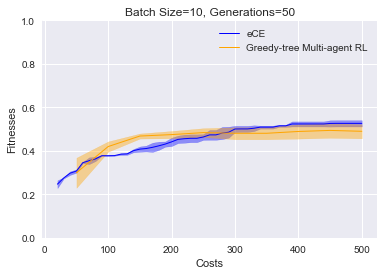

In [48]:
trials = 3
batch_size = 10
generations = 50
num_agents = 2
CE_data = [run_CE(initial_genotypes, batch_size, generations) for _ in range(trials)]
RL_data = [run_RL_multi_agent(initial_genotypes, batch_size, generations, 'greedy_future', num_agents) for _ in range(trials)]
np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
            batch_size=batch_size, generations=generations), CE_data)
np.save('./simulations/MARL/batch{batch_size}_generations{generations}_greedy-tree_2agents'.format(
            batch_size=batch_size, generations=generations), RL_data)
plot_data(CE_data,
          RL_data,
          batch_size=batch_size,
          generations=generations,
          labels=("eCE", "Greedy-tree Multi-agent RL")
         )

20 0.25882352941176473
30 0.2858823439654182
40 0.3694117602180032
50 0.3694117602180032
60 0.3694117602180032
70 0.3752941131591797
80 0.41882351146024815
90 0.4447058733771829
100 0.45764707677504596
110 0.45764707677504596
120 0.4588235294117647
130 0.4835293938131893
140 0.4835293938131893
150 0.4835293938131893
160 0.4835293938131893
170 0.4835293938131893
180 0.4835293938131893
190 0.4835293938131893
200 0.4835293938131893
210 0.4835293938131893
220 0.4835293938131893
230 0.4835293938131893
240 0.4835293938131893
250 0.4835293938131893
260 0.49764704984777114
270 0.49764704984777114
280 0.5082353030934054
290 0.5082353030934054
300 0.5082353030934054
310 0.5400000179515165
320 0.5400000179515165
330 0.5400000179515165
340 0.5400000179515165
350 0.5552941266228171
360 0.5552941266228171
370 0.5552941266228171
380 0.5552941266228171
390 0.5552941266228171
400 0.5552941266228171
410 0.5552941266228171
420 0.5552941266228171
430 0.5552941266228171
440 0.5552941266228171
450 0.5552941

220 0.48470589132869946 0.0009258166173822246
225 0.48470589132869946 0.0006840273796115071
233 0.48470589132869946 0.0008954869248555043
238 0.48470589132869946 0.0006566714953805785
245 0.48470589132869946 0.0008354039695404936
254 0.48470589132869946 0.0006215255067218095
261 0.48470589132869946 0.0008547127741621806
264 0.48470589132869946 0.0006253898383874912
274 0.48470589132869946 0.0008179613258107565
280 0.48470589132869946 0.0006923120519786608
283 0.48470589132869946 0.0008993290211947169
286 0.48470589132869946 0.0006463365665695164
293 0.48470589132869946 0.0008905709102691617
304 0.48470589132869946 0.0006408315195585601
309 0.48470589132869946 0.000744872642098926
313 0.48470589132869946 0.0005635068446281366
318 0.48470589132869946 0.0007634178022271953
326 0.48470589132869946 0.0005605627240584
329 0.48470589132869946 0.000679083324575913
335 0.48470589132869946 0.0005105302076117368
340 0.48470589132869946 0.0007106993762135971
346 0.48470589132869946 0.0005226221837

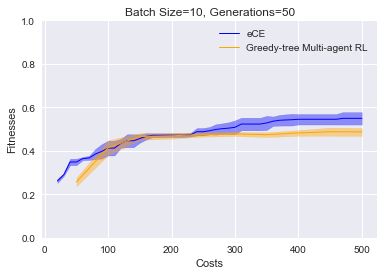

In [49]:
trials = 3
batch_size = 10
generations = 50
num_agents = 2
CE_data = [run_CE(initial_genotypes, batch_size, generations) for _ in range(trials)]
RL_data = [run_RL_multi_agent(initial_genotypes, batch_size, generations, 'greedy_future', num_agents) for _ in range(trials)]
np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
            batch_size=batch_size, generations=generations), CE_data)
np.save('./simulations/MARL/batch{batch_size}_generations{generations}_greedy-tree_2agents'.format(
            batch_size=batch_size, generations=generations), RL_data)
plot_data(CE_data,
          RL_data,
          batch_size=batch_size,
          generations=generations,
          labels=("eCE", "Greedy-tree Multi-agent RL")
         )